In [1]:
# util imports
import os
import random
import numpy as np

# pytorch imports
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

In [3]:
# define device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# path to train data
train_path = os.path.join('ucsc-cse-144-winter-2025-final-project', 'train', 'train')
print(train_path)

ucsc-cse-144-winter-2025-final-project\train\train


In [5]:
# composite the transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    # this should theoretically be wtvr the pretrained model was trained on
    transforms.Normalize(mean=(0.48, 0.48, 0.48), std=(0.0039, 0.0039, 0.0039))
])

In [6]:
import torchvision.models as models

In [7]:
# For example, if transforms are part of the feature extraction pipeline
print(models.VGG16_Weights.IMAGENET1K_FEATURES.transforms)


functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, mean=(0.48235, 0.45882, 0.40784), std=(0.00392156862745098, 0.00392156862745098, 0.00392156862745098))


In [8]:
trainset = datasets.ImageFolder(root=train_path, transform=transform)

In [9]:
# Accessing a single item to get its shape
train_images, train_labels = trainset[0]
print(f'Shape of an image tensor: {train_images.shape}')

Shape of an image tensor: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

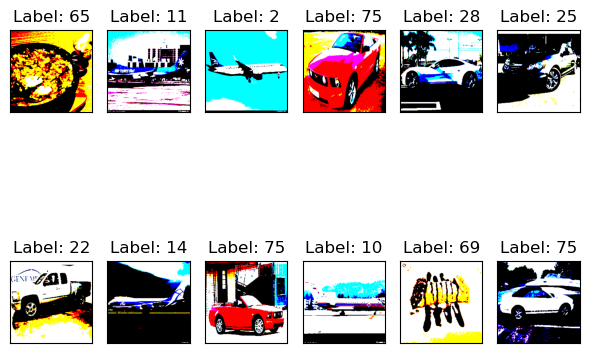

In [10]:
# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

fig, ax = plt.subplots(2, 6)
fig.set_size_inches(6, 6)

for i in range(2):
    for j in range(6):
        l=rn.randint(0, len(trainset))
        ax[i, j].imshow(np.transpose(trainset[l][0].numpy(), (1, 2, 0)), cmap='gray')
        ax[i, j].set_title('Label: ' + str(trainset[l][1]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()

In [11]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)

In [12]:
class VGG16Head(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG16Head, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [13]:
from torchvision.models import vgg16, VGG16_Weights

In [14]:
base_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
net = VGG16Head().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Training the network
num_epochs = 1
train_losses = []
train_acc = []

In [16]:
len(train_loader)

8

In [ ]:
def calculate_accuracy(loader, model, base_model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images.to(device)
            labels.to(device)
            with torch.no_grad():
              # The VGG is frozen
              vgg_features = base_model.features(images)
            outputs = net(vgg_features)
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [18]:
for epoch in range(num_epochs):
    net.train()
    running_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images.to(device)
        targets.to(device)

        # pass the data through the frozen model
        # .features() makes sure we don't get the FCLs
        with torch.no_grad():
            vgg_features = base_model.features(images)

        preds = net(vgg_features)
        loss = loss_fn(preds, targets)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_value = loss.item()
        running_loss += loss_value
        print(f"epoch: {epoch}, iteration: {i}, loss: {loss:>7f}")

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, net, base_model)
    train_acc.append(train_accuracy)


epoch: 0, iteration: 0, loss: 21.423252
epoch: 0, iteration: 1, loss: 17.887787
epoch: 0, iteration: 2, loss: 15.700887
epoch: 0, iteration: 3, loss: 14.340180
epoch: 0, iteration: 4, loss: 12.965681
epoch: 0, iteration: 5, loss: 12.471341
epoch: 0, iteration: 6, loss: 11.217582
epoch: 0, iteration: 7, loss: 10.959981


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
# plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()